# Programming

## Utils

In [2]:
import os
from os.path import join
from tqdm import tqdm
from scipy.io.wavfile import read, write
import xml.etree.ElementTree as ET
from librosa import time_to_samples as librosa_time_to_samples
from librosa import samples_to_frames as librosa_samples_to_frames
import numpy as np

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MEL2 as MelSpectrogram
from torchaudio.transforms import F2M

from maptask.utils import get_paths, load_audio, visualize_datapoint, sound_datapoint

## Maptask

This class iterates through the annotations provided by maptask and
extracts
backchannel uttterences.

The annotations in the dataset contains words
spoken and correlating timings.
Utterences from one speaker seperated by less
than `pause` are combined to make
a longer utterence, a sentence.

All
utterences which only contains one word are extracted and sorted by
popularity.
From this list of one word utterences the most common ones which
are known to be
back channels are then extracted.

As of now this means that the 6 words below
make up all utterences in the
dataset:

back\_channels = ['right', 'okay',
'mmhmm', 'uh-huh', 'yeah', 'mm']

This class stores all extracted backchannels
in a list where each entry in the
list is a dict[ 'name', 'time', 'sample',
'words' ]

Here 'name' is the name of the session, 'time' (seconds) and
'sample'(array
index) are the timings of the utterence and 'words' is a list of
strings.

In [3]:
# Annotation
class Maptask(object):
    '''
    This class iterates through the annotations provided by maptask and extracts
    backchannel uttterences.

    The annotations in the dataset contains words spoken and correlating timings.
    Utterences from one speaker seperated by less than `pause` are combined to
    make a longer utterence, a sentence.

    All utterences which only contains one word are extracted and sorted by
    popularity. From this list of one word utterences the most common ones which
    are known to be back channels are then extracted.

    As of now this means that the 6 words below make up all utterences in the
    dataset:

    self.back_channels = ['right', 'okay', 'mmhmm', 'uh-huh', 'yeah', 'mm']

    This class stores all extracted backchannels in a list where each entry in
    the list is a dict:

        {'name': name, 'time', time, 'sample': sample, 'words': words}

    Here 'name' is the name of the session, 'time' and 'sample' are the timings of
    the utterence and 'words' is a list of strings.
    '''

    def __init__(self, pause=0.2, max_utterences=1, root=None):
        self.paths = get_paths(root)
        self.session_names = self._session_names()

        self.pause = pause
        self.max_utterences = max_utterences
        self.back_channels = ['right', 'okay', 'mmhmm', 'uh-huh', 'yeah', 'mm']

        f_data, g_data = self.extract_all_short_utterence_from_both_users()
        self.f_utter, self.f_vocab = self.get_utterences(f_data)
        self.g_utter, self.g_vocab = self.get_utterences(g_data)

        self.back_channel_list = self.get_back_channel_list()
        # self.add_audio_signal_to_back_channel_data()

    def _session_names(self):
        return [fname.split('.')[0] for fname in \
                os.listdir(self.paths['dialog_path']) if fname.endswith('.wav')]

    def extract_tag_data_from_xml_path(self, xml_path=None):
        '''
        Extract timed-unit (tu), silence (si) and noise (noi) tags from the
        .xml annotation file.
        '''

        if not xml_path:
            raise OSError("xml path required")

        # parse xml
        xml_element_tree = ET.parse(xml_path)

        tu, words, sil, noi = [], [], [], []
        for elem in xml_element_tree.iter():
            try:
                tmp = (float(elem.attrib['start']), float(elem.attrib['end']))
            except:
                continue
            if elem.tag == 'tu':
                # elem.attrib: start, end, utt
                words.append(elem.text)  # word annotation
                tu.append(tmp)
            elif elem.tag == 'sil':
                # elem.attrib: start, end
                sil.append(tmp)
            elif elem.tag == 'noi':
                # elem.attrib: start, end, type='outbreath/lipsmack/...'
                noi.append(tmp)

        return {'tu': tu, 'silence': sil, 'noise': noi, 'words': words}

    def merge_pauses(self, tu, words):
        new_tu, new_words = [], []
        start, last_end, tmp_words = 0, 0, []
        for i, (t, w) in enumerate(zip(tu, words)):
            # t[0] - start,  t[1] - end
            pause_duration = t[0] - last_end
            if pause_duration > self.pause:
                new_tu.append((start, last_end))
                new_words.append(tmp_words)
                tmp_words = [w]
                start = t[0]
                last_end = t[1]
            else:
                tmp_words.append(w)
                last_end = t[1]
        return new_tu[1:], new_words[1:]  # remove first entry which is always zero

    def get_timing_utterences(self, name, user='f'):

        # load timed-units.xml. Searching through dir.
        for file in os.listdir(self.paths['timed_units_path']):
            if name in file:
                if '.'+user+'.' in file:
                    xml_path = join(self.paths['timed_units_path'], file)

        data = self.extract_tag_data_from_xml_path(xml_path)

        times, words = self.merge_pauses(data['tu'], data['words'])

        samples = librosa_time_to_samples(times, sr=20000)

        return [{'name': name, 'user': user, 'time':time, 'sample': sample, 'words': word} \
                for time, sample, word in zip(times, samples, words)]

    def extract_all_short_utterence_from_both_users(self):
        f_data, g_data = [], []
        for name in tqdm(self.session_names):
            f_data.append(self.get_timing_utterences(name, user='f'))
            g_data.append(self.get_timing_utterences(name, user='g'))
        return f_data, g_data

    def get_utterences(self, data):
        utterence_data, vocab = [], {}
        for session in data:
            tmp_session_data = []
            for utterence in session:
                utter = utterence['words']
                if len(utter) <= self.max_utterences:
                    tmp_session_data.append(utterence)
                    if not utter[0] in vocab.keys():
                        vocab[utter[0]] = 1
                    else:
                        vocab[utter[0]] += 1
            utterence_data.append(tmp_session_data)

        vocab = sorted(vocab.items(), key=lambda t: t[1], reverse=True)
        return utterence_data, vocab

    def get_back_channel_list(self):
        back_channel_list = []
        for file_utters in self.f_utter + self.g_utter:
            for utter in file_utters:
                word = utter['words'][0]
                if word in self.back_channels:
                    back_channel_list.append(utter)
        return back_channel_list

    def print_vocab(self, top=5):
        f_dpoints, f_back = 0, []
        g_dpoints, g_back = 0, []
        for i in range(top):
            f_back.append(self.f_vocab[i][0])
            f_dpoints += self.f_vocab[i][1]
            g_back.append(self.g_vocab[i][0])
            g_dpoints += self.g_vocab[i][1]
        print('Guide:')
        print('Datapoints: ', g_dpoints)
        print('Vocab: ', g_back)
        print()
        print('Follower:')
        print('Datapoints: ', f_dpoints)
        print('Vocab: ', f_back)
        print()
        print('Total: ', g_dpoints + f_dpoints)
        print('-'*50)


## Maptask

This dataset goes through the annotations and extract relevant
backchannels.

A pause of 0.1 seconds means that all utterences seperated by
less than 0.1 seconds are
concatonated into longer utterences. Then

In [4]:
pause = 0.5
max_utterences = 1

maptask = Maptask(pause, max_utterences)

print(len(maptask.back_channel_list))

100%|██████████| 127/127 [00:00<00:00, 175.44it/s]

4812


## Dataset

The PyTorch Dataset class uses the maptask class above in order to
get the
relevant annotations. First all the audio is loaded from the
maptask.paths['dialog\_path'] for faster extraction during training.

The audio
is loaded using `torchaudio.load` and if `normalize_audio=True` (True by
default) then the audio is normalized by dividing by the maximum value in the
audio array (relative normalization).

In [5]:
# Dataset
class MaptaskDataset(Dataset):
    ''' 128 dialogs, 16-bit samples, 20 kHz sample rate, 2 channels per conversation '''
    def __init__(self,
                 pause=0.5,
                 context=2,
                 max_utterences=1,
                 sample_rate=20000,
                 use_spectrogram=True,
                 window_size=512,
                 hop_length=256,
                 n_fft=None,
                 pad=0,
                 n_mels=40,
                 torch_load_audio=True,
                 audio=None,
                 normalize_audio=True,
                 root=None):
        self.maptask = Maptask(pause, max_utterences, root)
        self.paths = self.maptask.paths

        # Mel
        self.use_spectrogram = use_spectrogram
        self.sample_rate = sample_rate
        self.window_size = window_size
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.pad = pad
        self.n_mels = n_mels

        self.mel_spec = MelSpectrogram(sr=self.sample_rate,
                                       ws=self.window_size,
                                       hop=self.hop_length,
                                       n_fft=self.n_fft,
                                       pad=self.pad,
                                       n_mels=self.n_mels)
        # Audio
        self.normalize_audio = normalize_audio
        self.context = context
        self.torch_load_audio = torch_load_audio
        if audio:
            self.audio = audio
        else:
            self.audio = load_audio(self.paths['dialog_path'],
                                    self.torch_load_audio,
                                    self.normalize_audio)

    def __len__(self):
        return len(self.maptask.back_channel_list)

    def griffin_lim(self, magnitude, iters=30):
        '''
        based on:
        https://github.com/soobinseo/Tacotron-pytorch/blob/master/data.py
        in turn based on:
        librosa implementation of Griffin-Lim
        Based on https://github.com/librosa/librosa/issues/434
        '''
        angles = np.exp(2j * np.pi * np.random.rand(*magnitude.shape))
        S_complex = np.abs(magnitude).astype(np.complex)
        y = librosa.istft(S_complex * angles)
        for i in range(iters):
            _, angles = librosa.magphase(librosa.stft(y))
            y = librosa.istft(S_complex * angles)
        return y

    def __getitem__(self, idx):
        bc = self.maptask.back_channel_list[idx]
        start, end = bc['sample']

        n_samples = librosa_time_to_samples(self.context, sr=self.sample_rate)
        context = torch.zeros(n_samples)
        back_channel = torch.zeros(n_samples)

        # Find start of context >= 0
        context_start = end - n_samples
        if context_start < 0:
            context_start = 0

        y = self.audio[bc['name']]  # load correct audio array
        if bc['user'] == 'f':
            # back channel generator is 'f'
            tmp_context = y[context_start:end, 0]
            tmp_back_channel = y[context_start:end, 1]
        else:
            # back channel generator is 'g'
            tmp_context = y[context_start:end, 1]
            tmp_back_channel = y[context_start:end,0]

        context[-tmp_context.shape[0]:] = tmp_context
        back_channel[-back_channel.shape[0]:] = tmp_back_channel

        n_samples_bc = end - start
        back_channel_class = torch.zeros(back_channel.shape)
        back_channel_class[-n_samples_bc:] = 1

        # Spectrograms
        if self.use_spectrogram:
            context_spec = self.mel_spec(context.unsqueeze(0)).squeeze(0)
            back_channel_spec = self.mel_spec(back_channel.unsqueeze(0)).squeeze(0)

            bc_frames = librosa_samples_to_frames(n_samples_bc, hop_length=self.hop_length)
            back_channel_spec_class = torch.zeros(back_channel_spec.shape[0])
            back_channel_spec_class[-bc_frames:] = 1

            return {'context_audio': context,
                    'context_spec': context_spec,
                    'back_channel_audio': back_channel,
                    'back_channel_spec': back_channel_spec,
                    'back_channel_class': back_channel_class,
                    'back_channel_spec_class': back_channel_spec_class,
                    'back_channel_word': bc['words'][0]}
        else:
            return {'context_audio': context,
                    'back_channel_audio': back_channel,
                    'back_channel_class': back_channel_class,
                    'back_channel_word': bc['words'][0]}

Creating a dataset where utterances separated by less then are concatenated and
utterances containing one word and that word is in `back_channel_list` it counts
as a backchannel.

In [6]:
print('Creating Dataset and loading audio')
dset = MaptaskDataset(pause=0.5, max_utterences=1)
print('Dataset: ', len(dset))

 17%|█▋        | 22/127 [00:00<00:00, 164.80it/s]

Creating Dataset and loading audio


100%|██████████| 129/129 [00:20<00:00,  6.15it/s]

Dataset:  4812


DataLoader,
parallel loading, transform, collate

In [7]:
# DataLoaders
class MaptaskAudioDataloader(DataLoader):
    def __init__(self, dset, batch_size, pred, seq_len, overlap_len, *args, **kwargs):
        super().__init__(dset, batch_size, *args, **kwargs)
        self.seq_len = seq_len
        self.overlap_len = overlap_len
        self.pred = pred

    def __iter__(self):
        for batch in super().__iter__():
            # batch['back_channel_audio'].shape)
            # batch['context_audio'].shape)
            # batch['back_channel_class'].shape)
            (batch_size, n_samples) = batch['back_channel_audio'].shape

            reset = True
            for seq_begin in range(self.overlap_len, n_samples, self.seq_len):
                start = seq_begin - self.overlap_len
                end = seq_begin + self.seq_len

                bc_seq = batch['back_channel_audio'][:, start:end]
                context_seq = batch['context_audio'][:, start:end]
                input_seq = (context_seq[:,:-self.pred], bc_seq[:,:-self.pred])
                target_seq = bc_seq[:, self.overlap_len:].contiguous()
                yield (input_seq, reset, target_seq)
                reset = False


class MaptaskSpecDataloader(DataLoader):
    def __init__(self, dset, batch_size, pred, seq_len, overlap_len, *args, **kwargs):
        super().__init__(dset, batch_size, *args, **kwargs)
        self.seq_len = seq_len
        self.overlap_len = overlap_len
        self.pred = pred

    def __iter__(self):
        for batch in super().__iter__():
            # batch['context_spec'].shape
            # batch['back_channel_spec'].shape
            # batch['back_channel_spec_class'].shape
            (batch_size, n_frames, features) = batch['back_channel_spec'].shape

            reset = True
            for seq_begin in range(self.overlap_len, n_frames, self.seq_len):
                start = seq_begin - self.overlap_len
                end = seq_begin + self.seq_len

                bc_seq = batch['back_channel_spec'][:, start:end]
                bc_class = batch['back_channel_spec_class'][:, start:end]
                context_seq = batch['context_spec'][:, start:end]

                input_seq = (context_seq[:,:-self.pred], bc_seq[:,:-self.pred])
                target_seq = bc_seq[:, self.overlap_len:].contiguous()
                target_class = bc_class[:, self.overlap_len:].contiguous()
                yield (input_seq, reset, target_seq, target_class)
                reset = False

For Audio

In [8]:

# ---------------------------------------------------------------------
print('Audio: DataLoader')
maploader = MaptaskAudioDataloader(dset, pred=1, seq_len=300, overlap_len=100, batch_size=128, num_workers=4)
for batch in maploader:
	print(type(batch))
	print(batch[0][0].shape)
	print(batch[0][1].shape)
	print(batch[1])
	print(batch[2].shape)
	ans = input('Press n for quit')
	if ans == 'n':
		break


Audio: DataLoader
<class 'tuple'>
torch.Size([128, 399])
torch.Size([128, 399])
True
torch.Size([128, 300])
Press n for quitn


Specializing dataloaders for efficiency?
For Spectrogram

In [9]:
    # ---------------------------------------------------------------------
    print('Spectrogram: DataLoader')
    maploader = MaptaskSpecDataloader(dset, pred=1, seq_len=10, overlap_len=2, batch_size=128, num_workers=4)
    for batch in maploader:
        print(type(batch))
        print(batch[0][0].shape)
        print(batch[0][1].shape)
        print(batch[1])
        print(batch[2].shape)
        print(batch[3].shape)
        ans = input('Press n for quit')
        if ans == 'n':
            break

    # ---------------------------------------------------------------------

Spectrogram: DataLoader
<class 'tuple'>
torch.Size([128, 11, 40])
torch.Size([128, 11, 40])
True
torch.Size([128, 10, 40])
torch.Size([128, 10])
Press n for quit
<class 'tuple'>
torch.Size([128, 11, 40])
torch.Size([128, 11, 40])
False
torch.Size([128, 10, 40])
torch.Size([128, 10])
Press n for quitn


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9a8f0c5a90>>
Traceback (most recent call last):
  File "/home/erik/miniconda3/envs/maptask/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/erik/miniconda3/envs/maptask/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/erik/miniconda3/envs/maptask/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/erik/miniconda3/envs/maptask/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/erik/miniconda3/envs/maptask/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/erik/miniconda3/e

Listen to random datapoints and display data.

Listen to audio datapoints


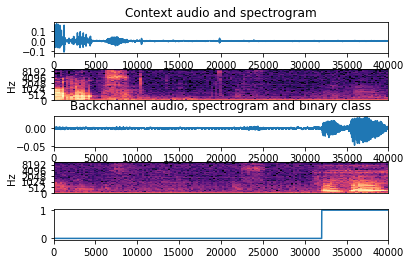

Play audio:  uh-huh
Press n for quit


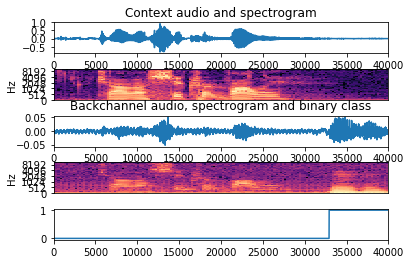

Play audio:  mmhmm
Press n for quit


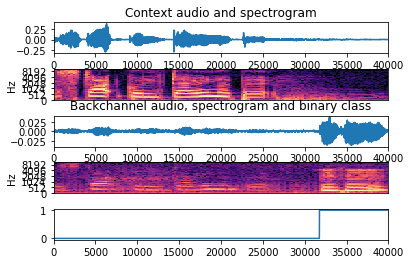

Play audio:  mmhmm
Press n for quitn


In [10]:
    print('Listen to audio datapoints')
    while True:
        idx = int(torch.randint(len(dset), (1,)).item())
        output = dset[idx]
        visualize_datapoint(output)
        sound_datapoint(output)
        ans = input('Press n for quit')
        if ans == 'n':
            break